In [36]:
!pip install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [37]:
# basic libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# community detection
import community as community_louvain  # louvain
import igraph as ig
import leidenalg
from networkx.algorithms.community import label_propagation_communities

# for visualization
import seaborn as sns
import matplotlib.cm as cm

In [55]:
import pandas as pd

# load user-artist interaction data
user_artist_df = pd.read_csv("../data/raw/hetrec2011-lastfm-2k/user_artists.dat", sep="\t")

# load artist metadata
artist_df = pd.read_csv("../data/raw/hetrec2011-lastfm-2k/artists.dat", sep="\t", encoding="latin1")[['id', 'name']]
artist_df.columns = ['artist_id', 'artist_name']

# merge the two datasets
merged_df = pd.merge(user_artist_df, artist_df, left_on='artistID', right_on='artist_id')
merged_df = merged_df[['userID', 'artistID', 'weight', 'artist_name']]

merged_df.head()

,userID,artistID,weight,artist_name
0,2,51,13883,Duran Duran
1,2,52,11690,Morcheeba
2,2,53,11351,Air
3,2,54,10300,Hooverphonic
4,2,55,8983,Kylie Minogue


In [56]:
import networkx as nx

# create bipartite graph
B = nx.Graph()

# add user nodes
B.add_nodes_from(merged_df['userID'].unique(), bipartite=0)

# add artist nodes
B.add_nodes_from(merged_df['artistID'].unique(), bipartite=1)

# add edges with weights
for _, row in merged_df.iterrows():
    B.add_edge(row['userID'], row['artistID'], weight=row['weight'])

In [57]:
# get only the user nodes
user_nodes = [n for n, d in B.nodes(data=True) if d['bipartite'] == 0]

# project bipartite graph to user-user graph
user_graph = nx.bipartite.weighted_projected_graph(B, user_nodes)

print("number of users:", user_graph.number_of_nodes())
print("number of user-user edges:", user_graph.number_of_edges())

number of users: 6282
number of user-user edges: 22038


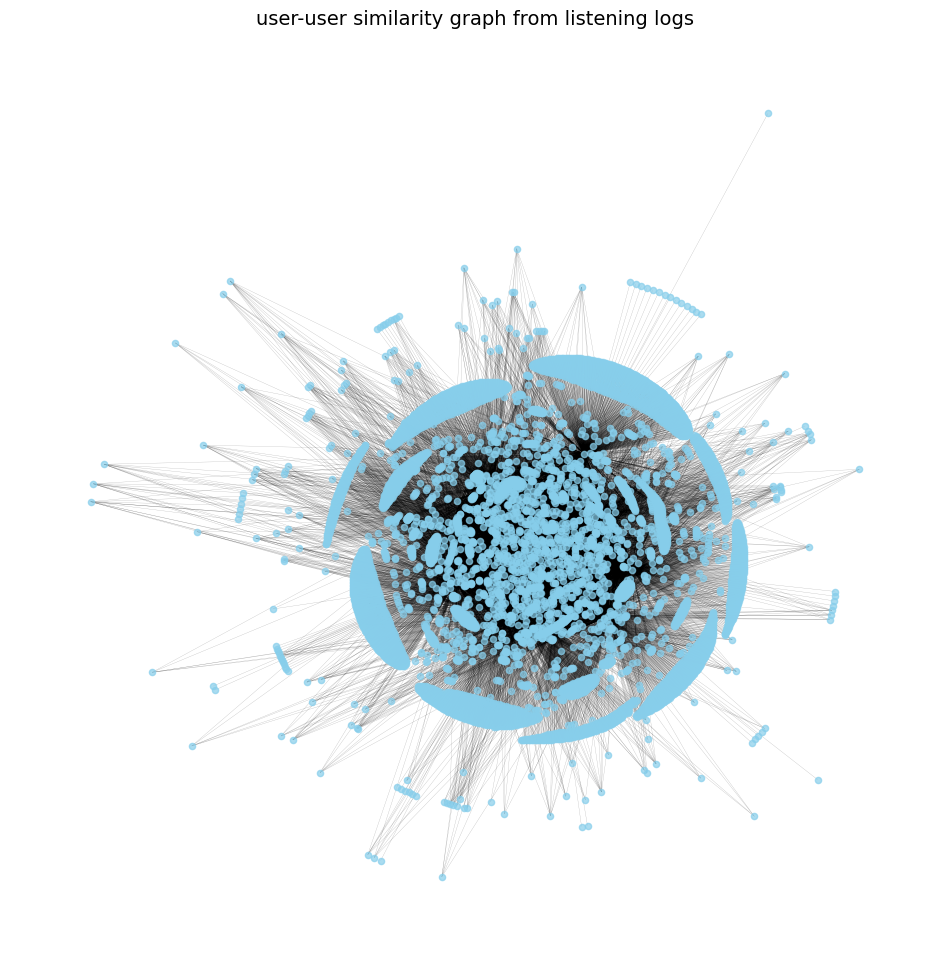

In [58]:
import matplotlib.pyplot as plt

# compute positions with repulsion
pos = nx.kamada_kawai_layout(user_graph)

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(user_graph, pos, node_size=20, node_color='skyblue', alpha=0.7)
nx.draw_networkx_edges(user_graph, pos, width=0.2, alpha=0.3)
plt.title("user-user similarity graph from listening logs", fontsize=14)
plt.axis('off')
plt.show()

In [59]:
import community as community_louvain

# apply Louvain community detection
louvain_partition = community_louvain.best_partition(user_graph, weight='weight')

# attach communities to each node
nx.set_node_attributes(user_graph, louvain_partition, 'louvain_community')

# number of communities
num_louvain_comms = len(set(louvain_partition.values()))
print("number of Louvain communities:", num_louvain_comms)

number of Louvain communities: 6


In [60]:
# apply label propagation
lpa_communities = nx.algorithms.community.label_propagation_communities(user_graph)
lpa_partition = {}

for i, community in enumerate(lpa_communities):
    for user in community:
        lpa_partition[user] = i

# attach communities to nodes
nx.set_node_attributes(user_graph, lpa_partition, 'lpa_community')

print("number of LPA communities:", len(set(lpa_partition.values())))

number of LPA communities: 1


In [62]:
pos = nx.spring_layout(user_graph, seed=42)

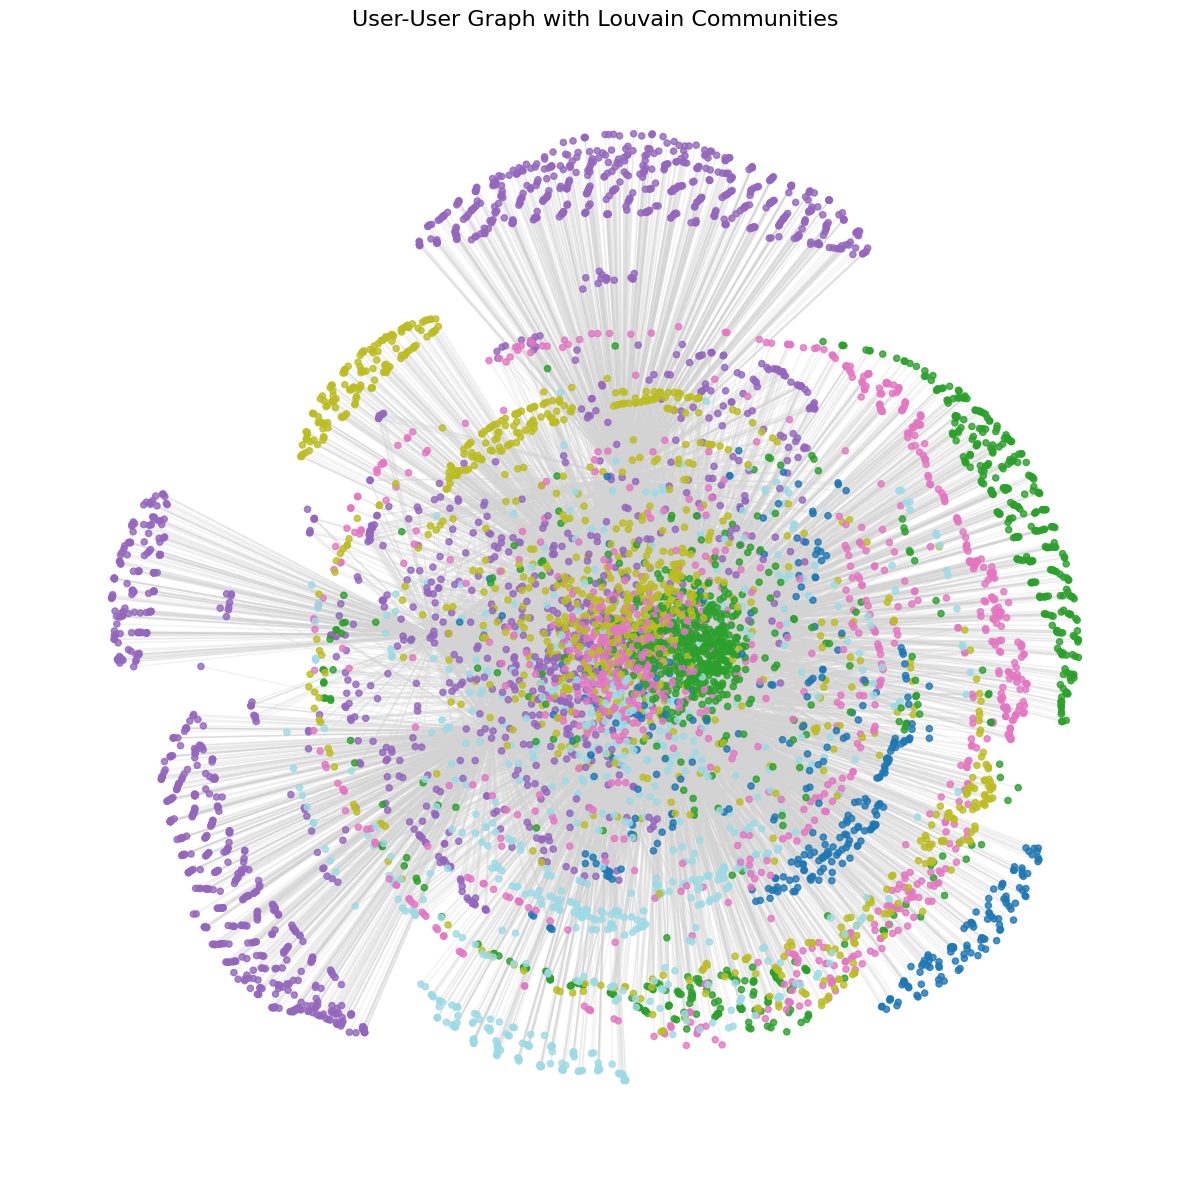

In [63]:
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(
    user_graph,
    pos,
    node_color=[louvain_partition[n] for n in user_graph.nodes()],
    cmap=plt.cm.tab20,
    node_size=20,
    alpha=0.8
)
nx.draw_networkx_edges(
    user_graph,
    pos,
    edge_color='lightgray',
    alpha=0.3
)
plt.title("User-User Graph with Louvain Communities", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig("figures/louvain_community_cleaned.png", dpi=300)
plt.show()

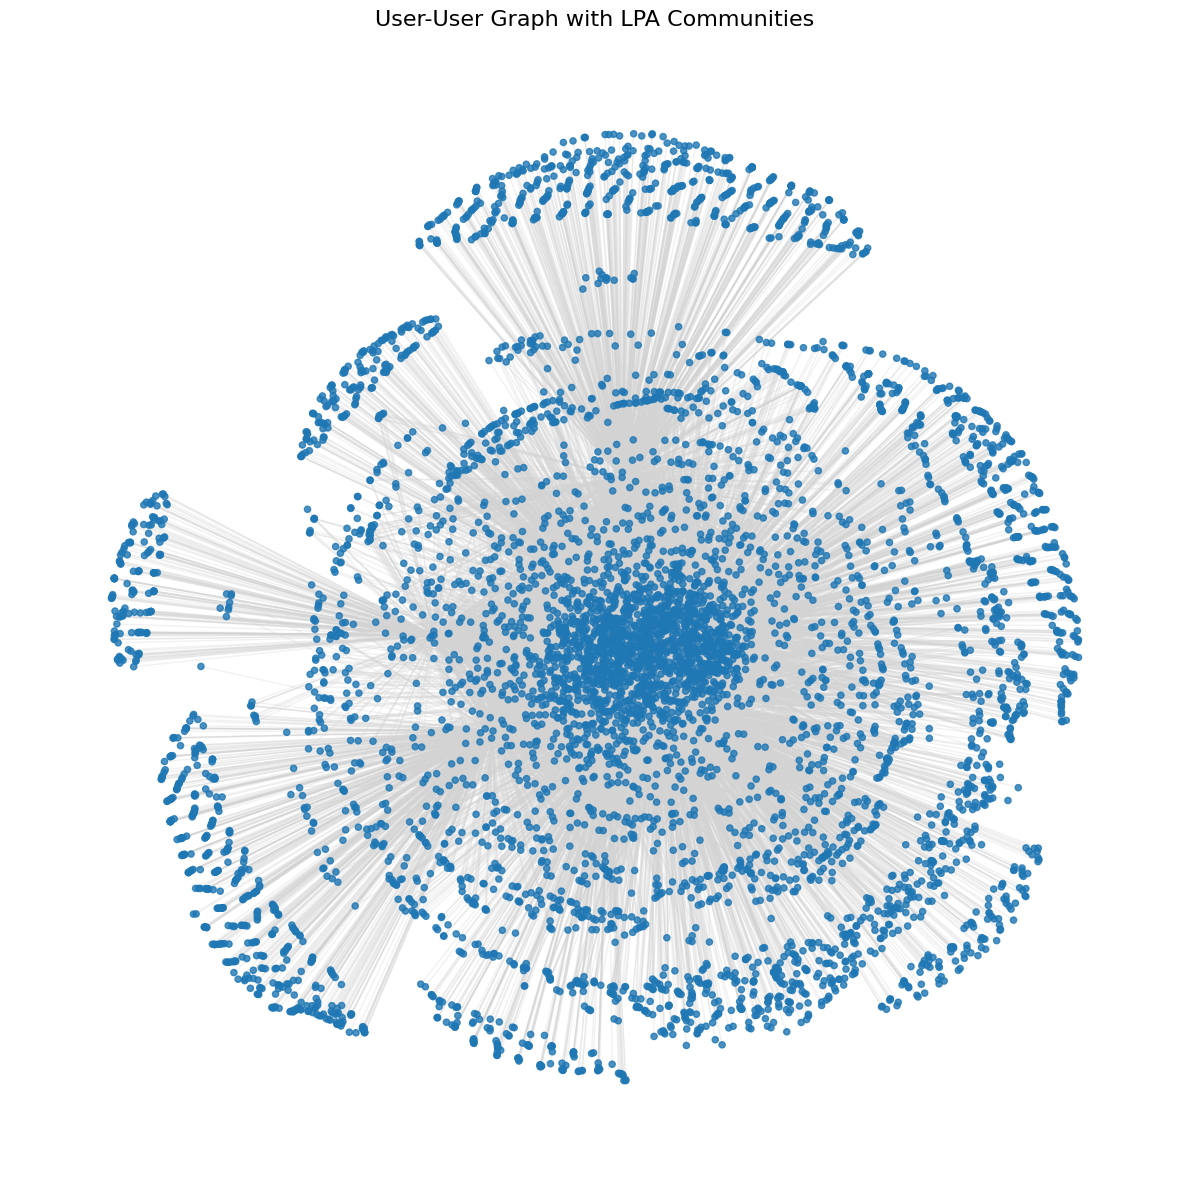

In [64]:
from networkx.algorithms.community import label_propagation_communities

# apply LPA
lpa_communities = list(label_propagation_communities(user_graph))

# map user to LPA community index
lpa_partition = {}
for i, comm in enumerate(lpa_communities):
    for user in comm:
        lpa_partition[user] = i

# plot
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(
    user_graph,
    pos,
    node_color=[lpa_partition[n] for n in user_graph.nodes()],
    cmap=plt.cm.tab20,
    node_size=20,
    alpha=0.8
)
nx.draw_networkx_edges(
    user_graph,
    pos,
    edge_color='lightgray',
    alpha=0.3
)
plt.title("User-User Graph with LPA Communities", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig("figures/lpa_community_cleaned.png", dpi=300)
plt.show()

In [65]:
# save louvain community assignments to csv
louvain_df = pd.DataFrame({'user_id': list(louvain_partition.keys()), 'louvain_community': list(louvain_partition.values())})
louvain_df.to_csv('../user_communities_louvain.csv', index=False)

# save lpa community assignments to csv
lpa_df = pd.DataFrame({'user_id': list(lpa_partition.keys()), 'lpa_community': list(lpa_partition.values())})
lpa_df.to_csv('../user_communities_lpa.csv', index=False)

we’ll calculate these node-level features:
- degree centrality
- betweenness centrality
- clustering coefficient
- pagerank

these will form our “harmonic vector” per user node.

In [66]:
# compute centrality metrics for each user
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
clustering_coeff = nx.clustering(G)
pagerank = nx.pagerank(G)

# build dataframe of all metrics
harmonic_df = pd.DataFrame({
    'user_id': list(G.nodes),
    'degree': [degree_centrality[n] for n in G.nodes],
    'betweenness': [betweenness_centrality[n] for n in G.nodes],
    'clustering': [clustering_coeff[n] for n in G.nodes],
    'pagerank': [pagerank[n] for n in G.nodes],
})

# optional: normalize all values to [0, 1] for fair fusion
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
harmonic_df.iloc[:, 1:] = scaler.fit_transform(harmonic_df.iloc[:, 1:])

# preview the harmonic metrics
harmonic_df.head()

,user_id,degree,betweenness,clustering,pagerank
0,2,0.000000,0.0,0.0,0.000000
1,3,0.000000,0.0,0.0,0.000000
2,4,0.004184,0.0,0.0,0.080257
3,5,0.000000,0.0,0.0,0.000000
4,6,0.000000,0.0,0.0,0.000000


In [67]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# set number of clusters — start with 6 (same as louvain) for fair comparison
num_clusters = 6

# fit kmeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
harmonic_df['harmonic_cluster'] = kmeans.fit_predict(harmonic_df[['degree', 'betweenness', 'clustering', 'pagerank']])

# save to csv
harmonic_df.to_csv('../user_communities_harmonic.csv', index=False)

# show counts
print(harmonic_df['harmonic_cluster'].value_counts())

harmonic_cluster
0    1273
2     186
4     173
1     104
3      99
5      57
Name: count, dtype: int64


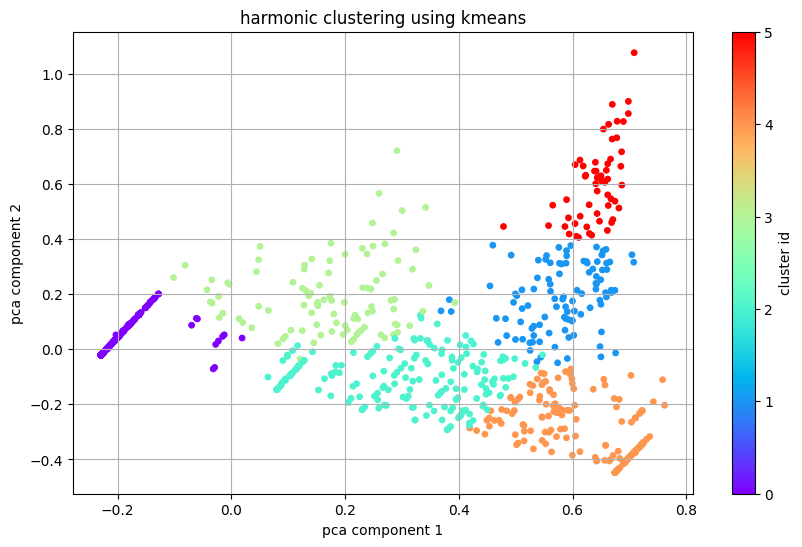

In [68]:
# reduce to 2D for visualization
pca = PCA(n_components=2)
harmonic_2d = pca.fit_transform(harmonic_df[['degree', 'betweenness', 'clustering', 'pagerank']])

# plot the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(harmonic_2d[:, 0], harmonic_2d[:, 1], c=harmonic_df['harmonic_cluster'], cmap='rainbow', s=15)
plt.title('harmonic clustering using kmeans')
plt.xlabel('pca component 1')
plt.ylabel('pca component 2')
plt.colorbar(scatter, label='cluster id')
plt.grid(True)
plt.show()

In [71]:
louvain_communities = dict(louvain_partition)
lpa_communities = dict(lpa_partition)

In [72]:
# add louvain and lpa community labels to harmonic_df
harmonic_df['louvain_community'] = harmonic_df['user_id'].map(louvain_communities)
harmonic_df['lpa_community'] = harmonic_df['user_id'].map(lpa_communities)

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# make sure all labels are aligned
harmonic_labels = harmonic_df['harmonic_cluster']
louvain_labels = harmonic_df['louvain_community']
lpa_labels = harmonic_df['lpa_community']

# calculate ARI and NMI
ari_louvain = adjusted_rand_score(louvain_labels, harmonic_labels)
nmi_louvain = normalized_mutual_info_score(louvain_labels, harmonic_labels)

ari_lpa = adjusted_rand_score(lpa_labels, harmonic_labels)
nmi_lpa = noralized_mutual_info_score(lpa_labels, harmonic_labels)

print(f"ari (harmonic vs louvain): {ari_louvain:.4f}")
print(f"nmi (harmonic vs louvain): {nmi_louvain:.4f}")
print(f"ari (harmonic vs lpa): {ari_lpa:.4f}")
print(f"nmi (harmonic vs lpa): {nmi_lpa:.4f}")

ValueError: Input contains NaN.